In [87]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [24]:
# Create a mapping of countries to continents
country_to_continent = {
    'United States': 'North America',
    'Canada': 'North America',
    'China': 'Asia',
    'Germany': 'Europe',
    'Switzerland': 'Europe',
    'United Kingdom': 'Europe',
    'France': 'Europe',
    'Norway': 'Europe',
    'Philippines': 'Asia',
    'Spain': 'Europe',
    'Italy': 'Europe',
    'Australia': 'Oceania',
    'Denmark': 'Europe',
    'Poland': 'Europe',
    'Brazil': 'South America',
    'Japan': 'Asia',
    'Netherlands': 'Europe'
}

In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from matplotlib.ticker import MaxNLocator

# Function to extract and clean categories from a string
def extract_and_clean_categories(text):
    # Remove text within parentheses
    text = re.sub(r'\s*\(.*?\)', '', text)
    # Remove brackets and split by ','
    text = text.strip('[]')
    categories = [cat.strip() for cat in text.split(',')]
    return categories

# Function to insert a newline if the label is longer than 30 characters
def insert_newline(label, max_length=30):
    if len(label) > max_length:
        # Find the position of the nearest space after the max_length
        split_pos = label.find(' ', max_length)
        if split_pos != -1:
            return label[:split_pos] + '\n' + label[split_pos+1:]
    return label

def plot_categorical_by_continent(survey, question, category_name, exclude_categories=set()):
    # Get the unique categories across all continents, excluding the unwanted categories
    all_categories = set()
    for row in survey[question].dropna():
        categories = extract_and_clean_categories(row)
        categories = [cat for cat in categories if cat not in exclude_categories]
        all_categories.update(categories)
    
    all_categories = sorted(all_categories)  # Sort categories for consistent ordering
    
    # Create a mapping from original categories to formatted categories
    formatted_category_map = {cat: insert_newline(cat) for cat in all_categories}
    formatted_categories = list(formatted_category_map.values())

    # Create a Figure object
    fig, axes = plt.subplots(len(survey['Continent'].unique()), 1, figsize=(16, 12), sharex=True)
    
    # Ensure axes is always iterable
    if len(survey['Continent'].unique()) == 1:
        axes = [axes]
    
    # Get unique continents
    continents = survey['Continent'].unique()
    
    for i, continent in enumerate(continents):
        ax = axes[i]
        
        # Filter data for the current continent
        continent_data = survey[survey['Continent'] == continent]
        
        # Initialize a Counter to count occurrences
        counter = Counter()
        
        # Flatten the list of categories and count each one
        for row in continent_data[question].dropna():
            categories = extract_and_clean_categories(row)
            categories = [cat for cat in categories if cat not in exclude_categories]
            counter.update(categories)
        
        # Convert to DataFrame for plotting
        count_df = pd.DataFrame(counter.items(), columns=[category_name, 'Count'])
        count_df[category_name] = count_df[category_name].map(formatted_category_map)
        count_df = count_df.set_index(category_name).reindex(formatted_categories, fill_value=0).reset_index()
        
        # Plot the bar chart for the current continent
        sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
        ax.set_ylabel('Count')
        ax.set_title(f'{continent}', fontsize=14, fontweight='bold')
        
        # Set y-axis to show integer ticks only
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        
        # Set x-axis labels only for the bottom figure
        if i != len(continents) - 1:
            ax.set_xlabel('')  # Remove x-axis label for other subplots
            ax.set_xticks([])  # Remove x-ticks for other subplots
        else:
            ax.set_xlabel(category_name)
            ax.set_xticks(range(len(formatted_categories)))  # Set x-ticks positions
            ax.set_xticklabels(formatted_categories, rotation=55)  # Set x-tick labels and rotate
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig(f"{category_name.replace(' ', '_')}.png", bbox_inches='tight')
    plt.show()


In [241]:
replace_columns = {
    'Which country do you currently work in?': 'Which country do you reside?',
    'What is your academic/career stage?': 'What is your primary role?',
}

replace_values = {
    "0-8 years Early (e.g. grad student, postdoc, intern)": "Graduate Student",
    "9-15 years Mid (e.g. manager, assistant professor, associate professor)": "Faculty",
    "lack of funding": "Lack of funding",
    'Funds, time': "Lack of funding, time",
    "Funds": "Lack of funding",
    "Missing interoperability between standards and technology (e.g., scanner dependent pulse sequence protocols),not enough funding'": "Missing interoperability between standards and technology (e.g., scanner dependent pulse sequence protocols), Lack of funding",   
}

In [242]:
globe_survey = pd.read_csv('2024_07_30_survey.csv')
idor_survey = pd.read_csv('2024_07_30_idor_survey.csv')

idor_survey.replace(replace_values, inplace=True)
idor_survey.rename(columns=replace_columns, inplace=True)



survey = pd.concat([globe_survey, idor_survey])

survey.replace(replace_values, inplace=True)

Continent counts:
       Continent  Count
0  North America     30
1         Europe     16
2  South America      7
3           Asia      4
4        Oceania      3


/tmp/ipykernel_304359/400256359.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


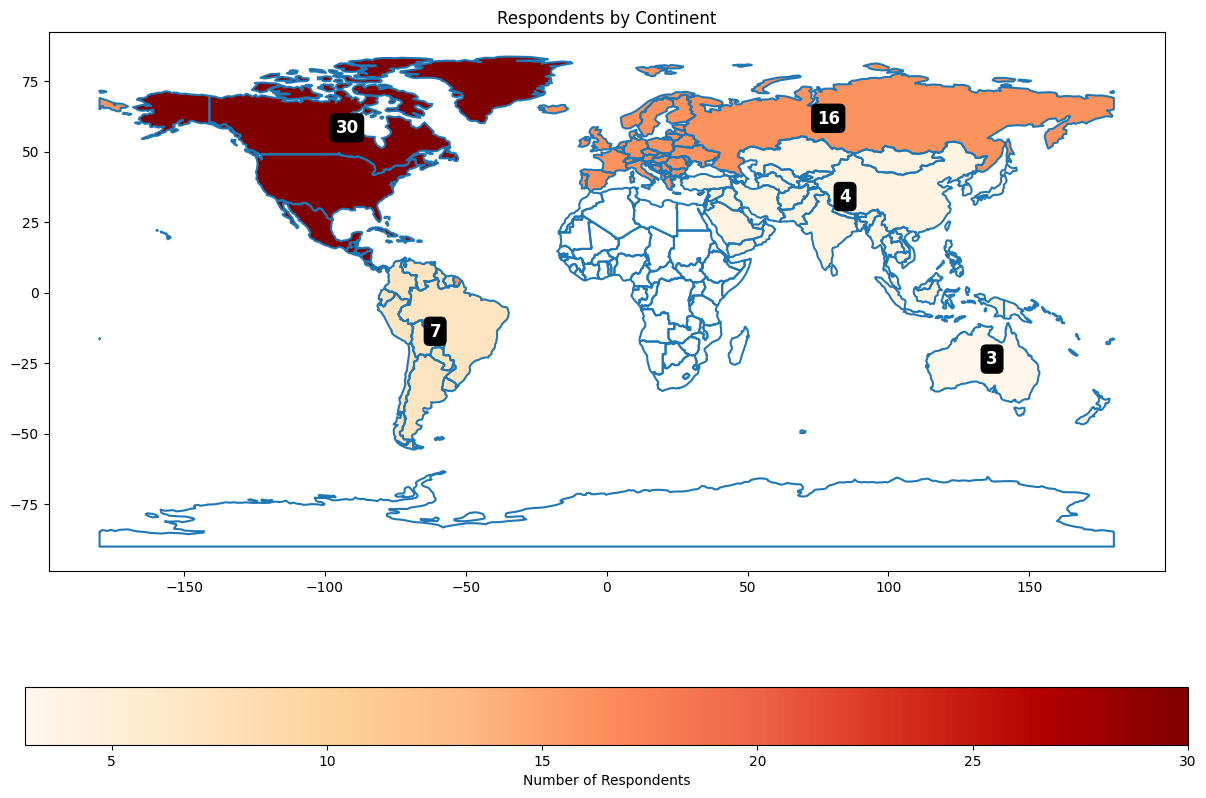

In [243]:
survey['Continent'] = survey['Which country do you reside?'].map(country_to_continent)

# Count the number of respondents per continent
continent_counts = survey['Continent'].value_counts().reset_index()
continent_counts.columns = ['Continent', 'Count']

# Display the continent counts
print("Continent counts:")
print(continent_counts)

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


# Aggregate the counts per continent
continent_counts_dict = continent_counts.set_index('Continent').to_dict()['Count']

# Assign counts to the continents in the world map
world['Count'] = world['continent'].map(continent_counts_dict)

# Plot the map with a heatmap effect
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)
world.plot(column='Count', ax=ax, legend=True, cmap='OrRd', legend_kwds={'label': "Number of Respondents", 'orientation': "horizontal"})

# Add labels for the counts
for continent, count in continent_counts_dict.items():
    # Calculate the centroid of the continent for the label position
    continent_geom = world[world['continent'] == continent].geometry.unary_union
    centroid = continent_geom.centroid
    plt.text(x=centroid.x, y=centroid.y, s=f"{count}", horizontalalignment='center', fontsize=12, fontweight='bold',
             color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.3'))


plt.title('Respondents by Continent')
plt.savefig("location.png", bbox_inches='tight')
plt.show()

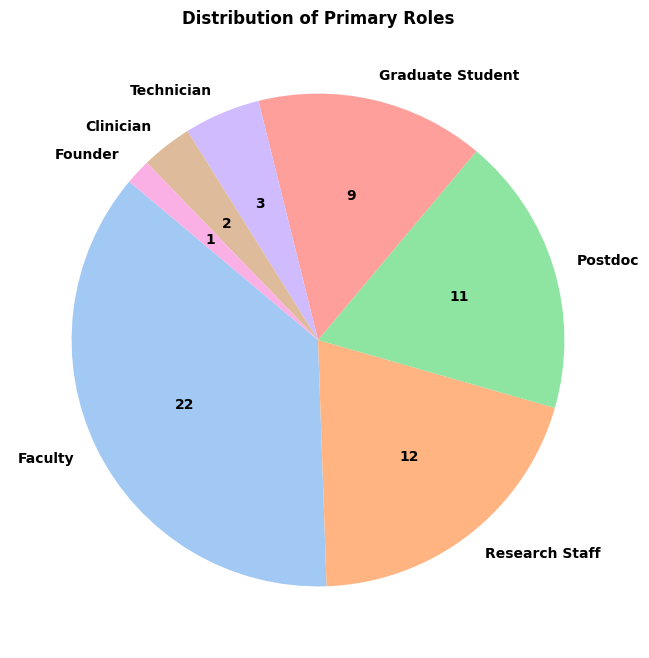

In [244]:
role_counts = survey['What is your primary role?'].value_counts()

# Define a function to format the labels with just the count
def func(pct, allvalues):
    absolute = int(pct / 100. * sum(allvalues))
    return f'{absolute}'

# Plot pie chart
plt.figure(figsize=(10, 8))
plt.pie(role_counts, labels=role_counts.index, textprops={'fontweight': 'bold'}, autopct=lambda pct: func(pct, role_counts), startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribution of Primary Roles', fontweight="bold")
plt.savefig("roles.png", bbox_inches='tight')
plt.show()

/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/home/jdkent/projects/BRIDGESurvey/.bsurvey/lib/python3.8/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be rem

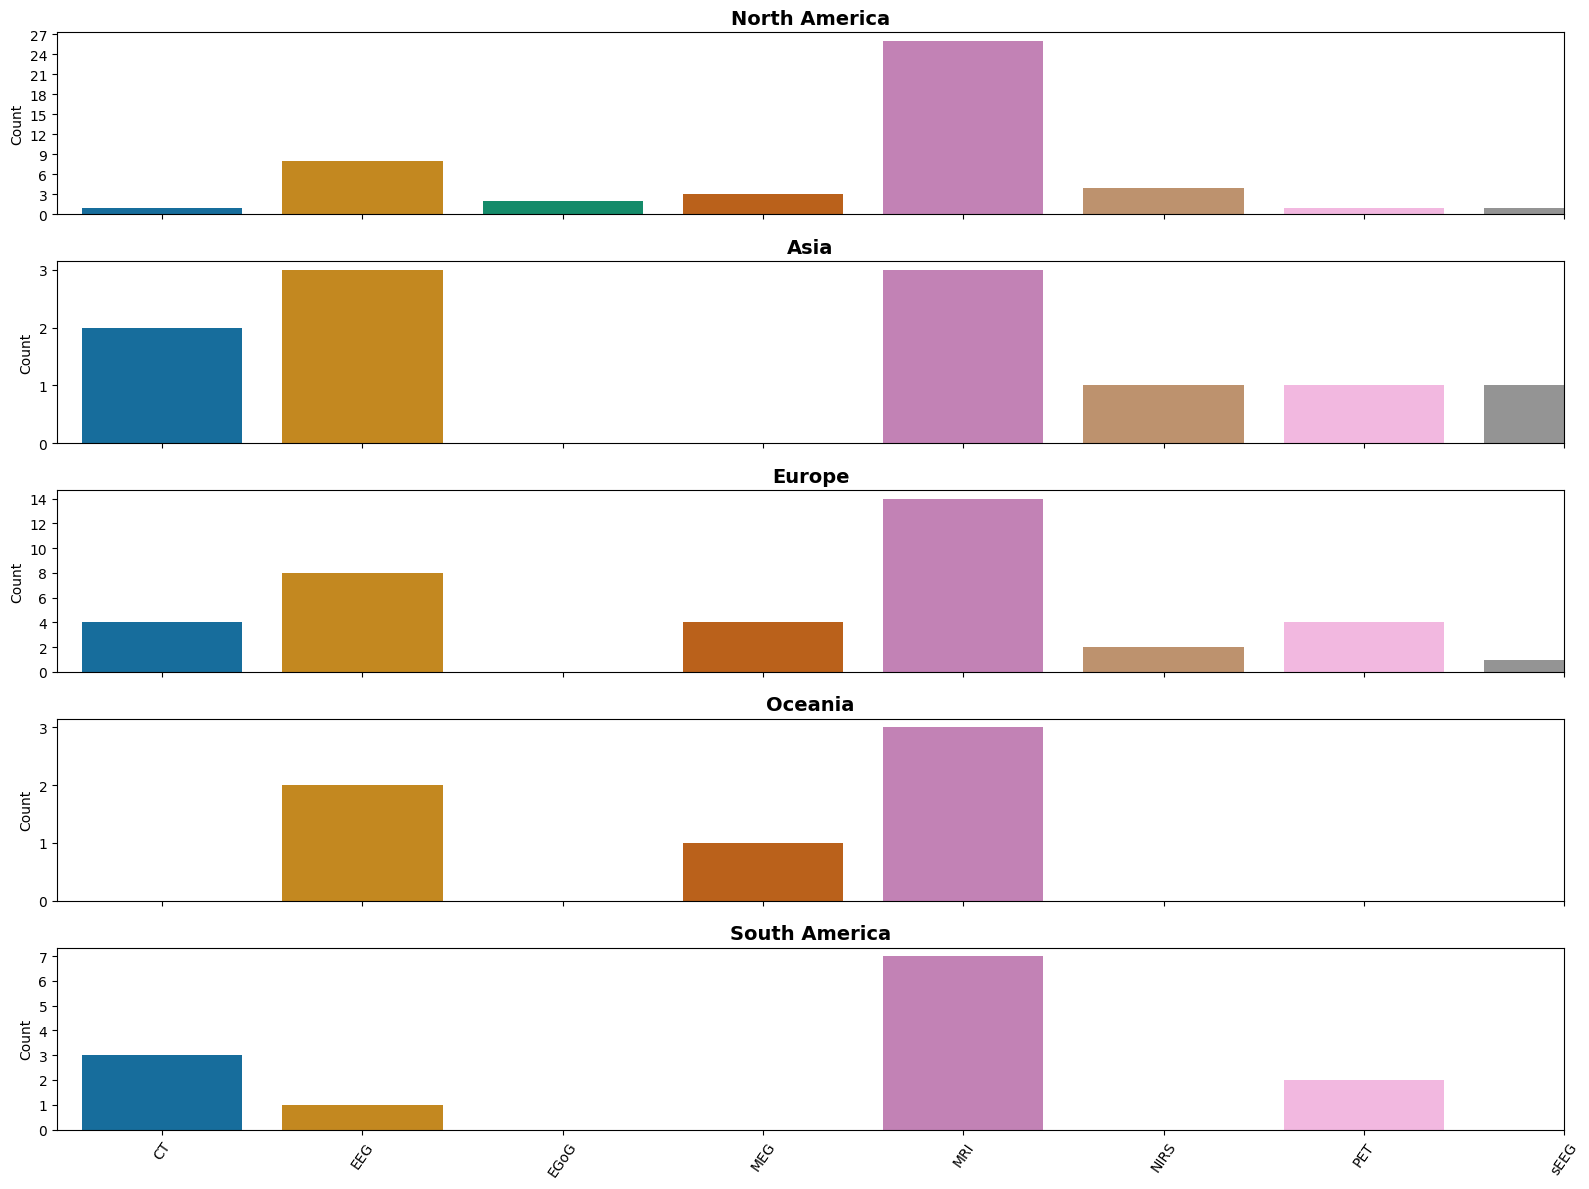

In [245]:
plot_categorical_by_continent(
    survey,
    "What types of neuroimaging data do you collect? (Check all that apply)",
    "Imaging Modality",
    {"Behavioral", "Synesthesia."}
)

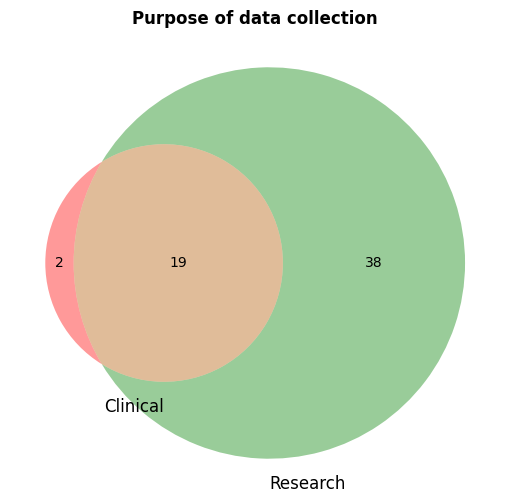

In [251]:

# Define sets for the Venn diagram
set_labels = ['Clinical', 'Research']
set_dict = {label: set() for label in set_labels}

# Populate sets based on categories
for index, category in survey.reset_index().iterrows():
    categories = category["What purpose(s) is the data being collected for?"].split(',')
    if 'Clinical' in categories and 'Research' in categories:
        set_dict['Clinical'].add(index)
        set_dict['Research'].add(index)
    elif 'Clinical' in categories:
        set_dict['Clinical'].add(index)
    elif 'Research' in categories:
        set_dict['Research'].add(index)

# Plot Venn Diagram
plt.figure(figsize=(8, 6))
venn = venn2([set_dict['Clinical'], set_dict['Research']], 
             set_labels)
plt.title('Purpose of data collection', fontweight="bold")
plt.savefig('purpose.png', bbox_inches="tight")
plt.show()

/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/home/jdkent/projects/BRIDGESurvey/.bsurvey/lib/python3.8/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be rem

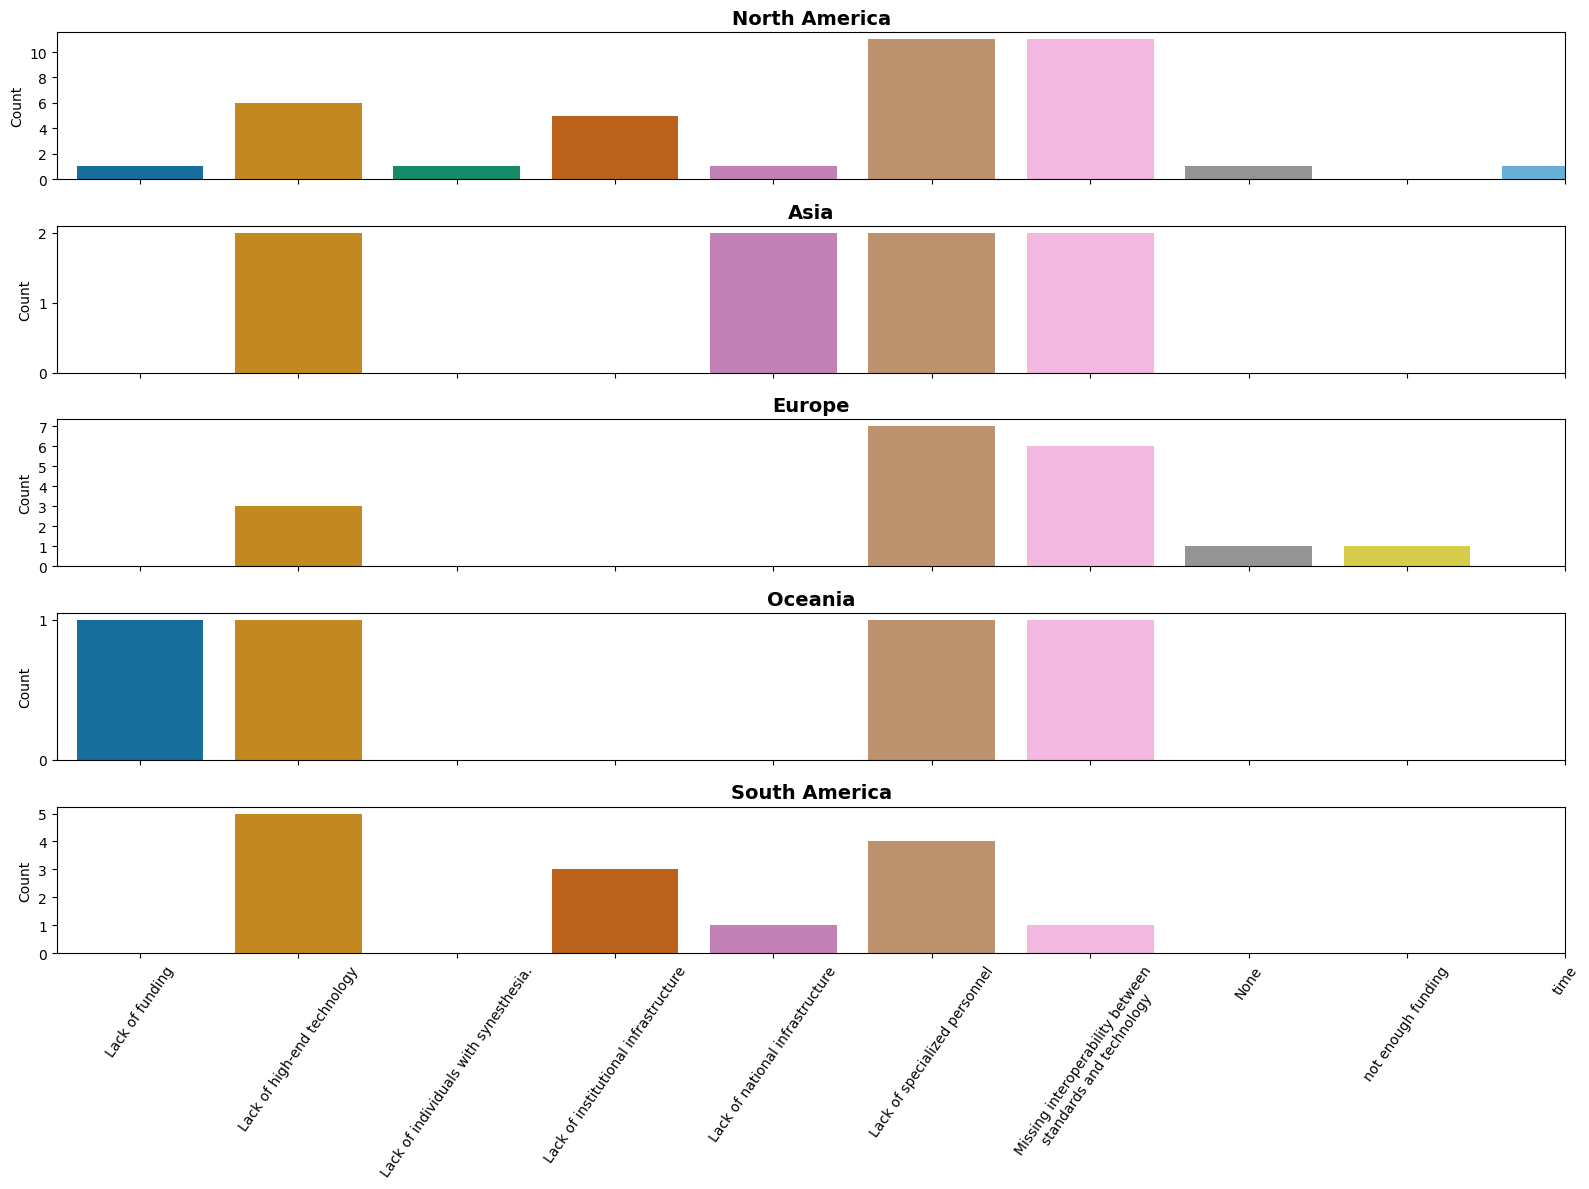

In [247]:
plot_categorical_by_continent(
    survey,
    "What are the top 3 challenges you have encountered generating data? (Can select fewer than 3)",
    "Data Generation Challenges",
)

/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/home/jdkent/projects/BRIDGESurvey/.bsurvey/lib/python3.8/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be rem

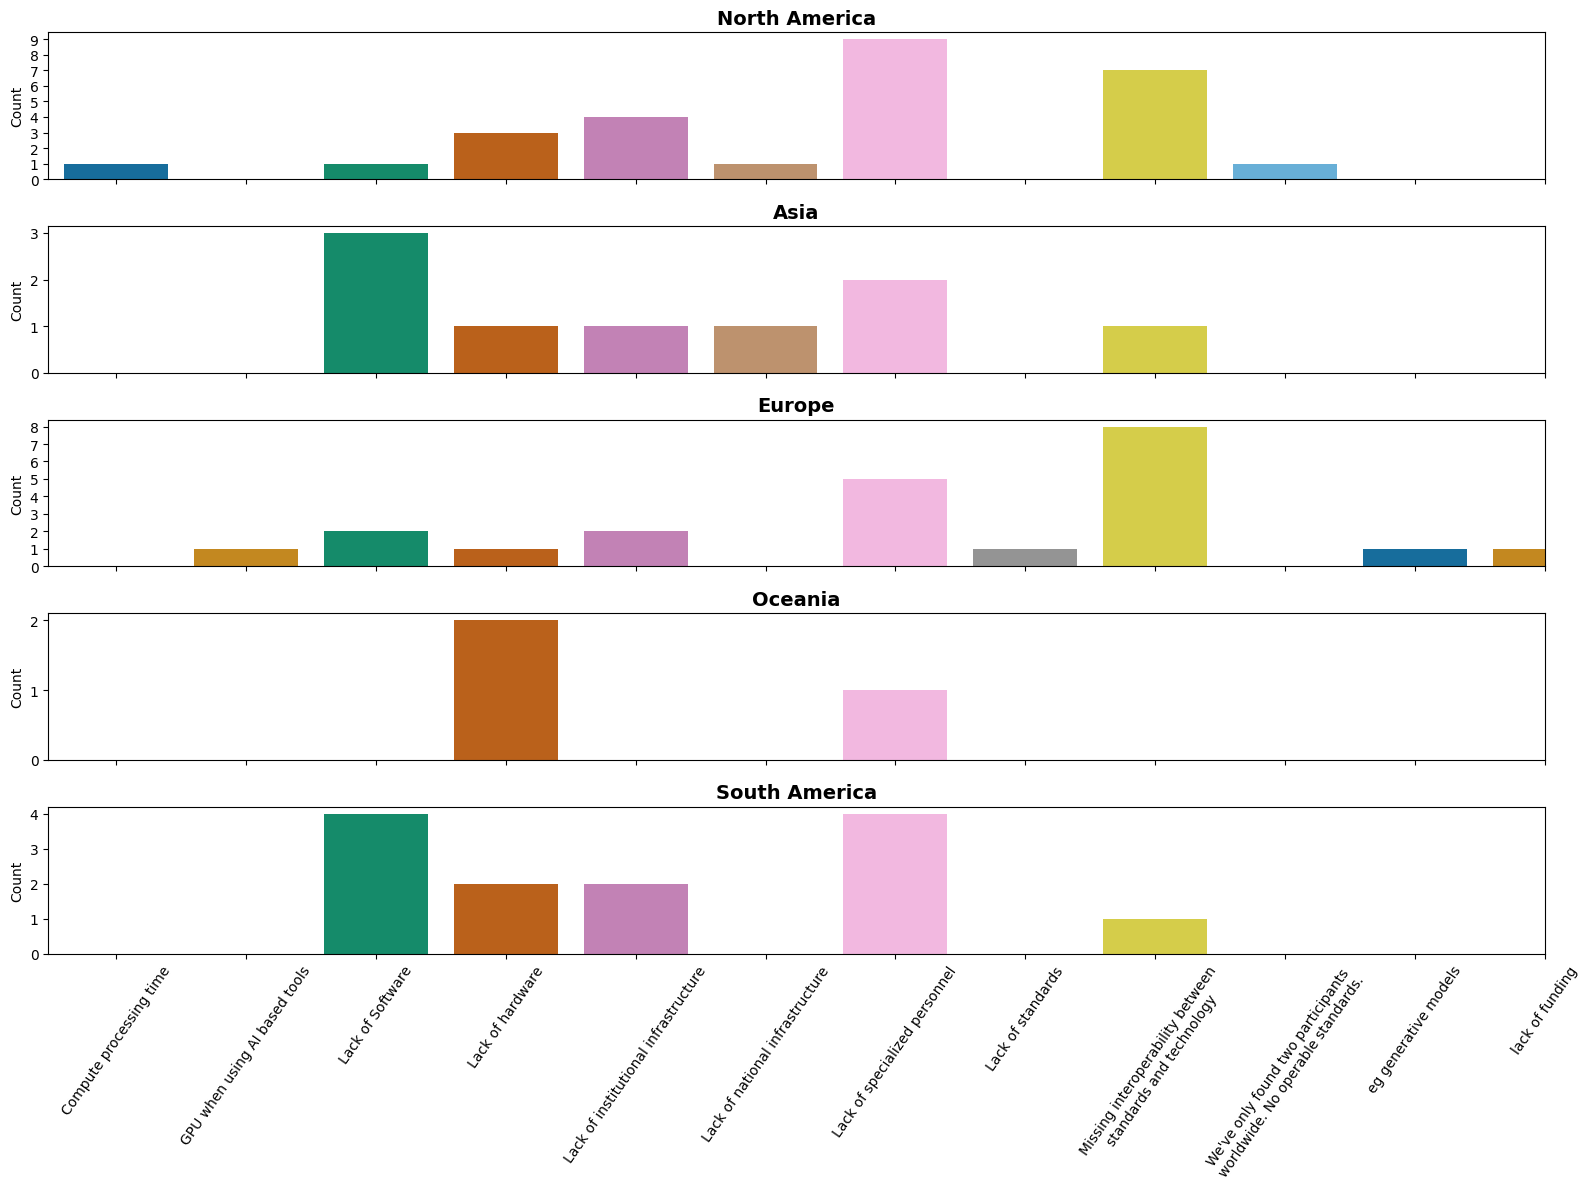

In [248]:
plot_categorical_by_continent(
    survey,
    "What are the barriers to processing your data? (Check all that apply)",
    "Data Processing Challenges",
)

/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/home/jdkent/projects/BRIDGESurvey/.bsurvey/lib/python3.8/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be rem

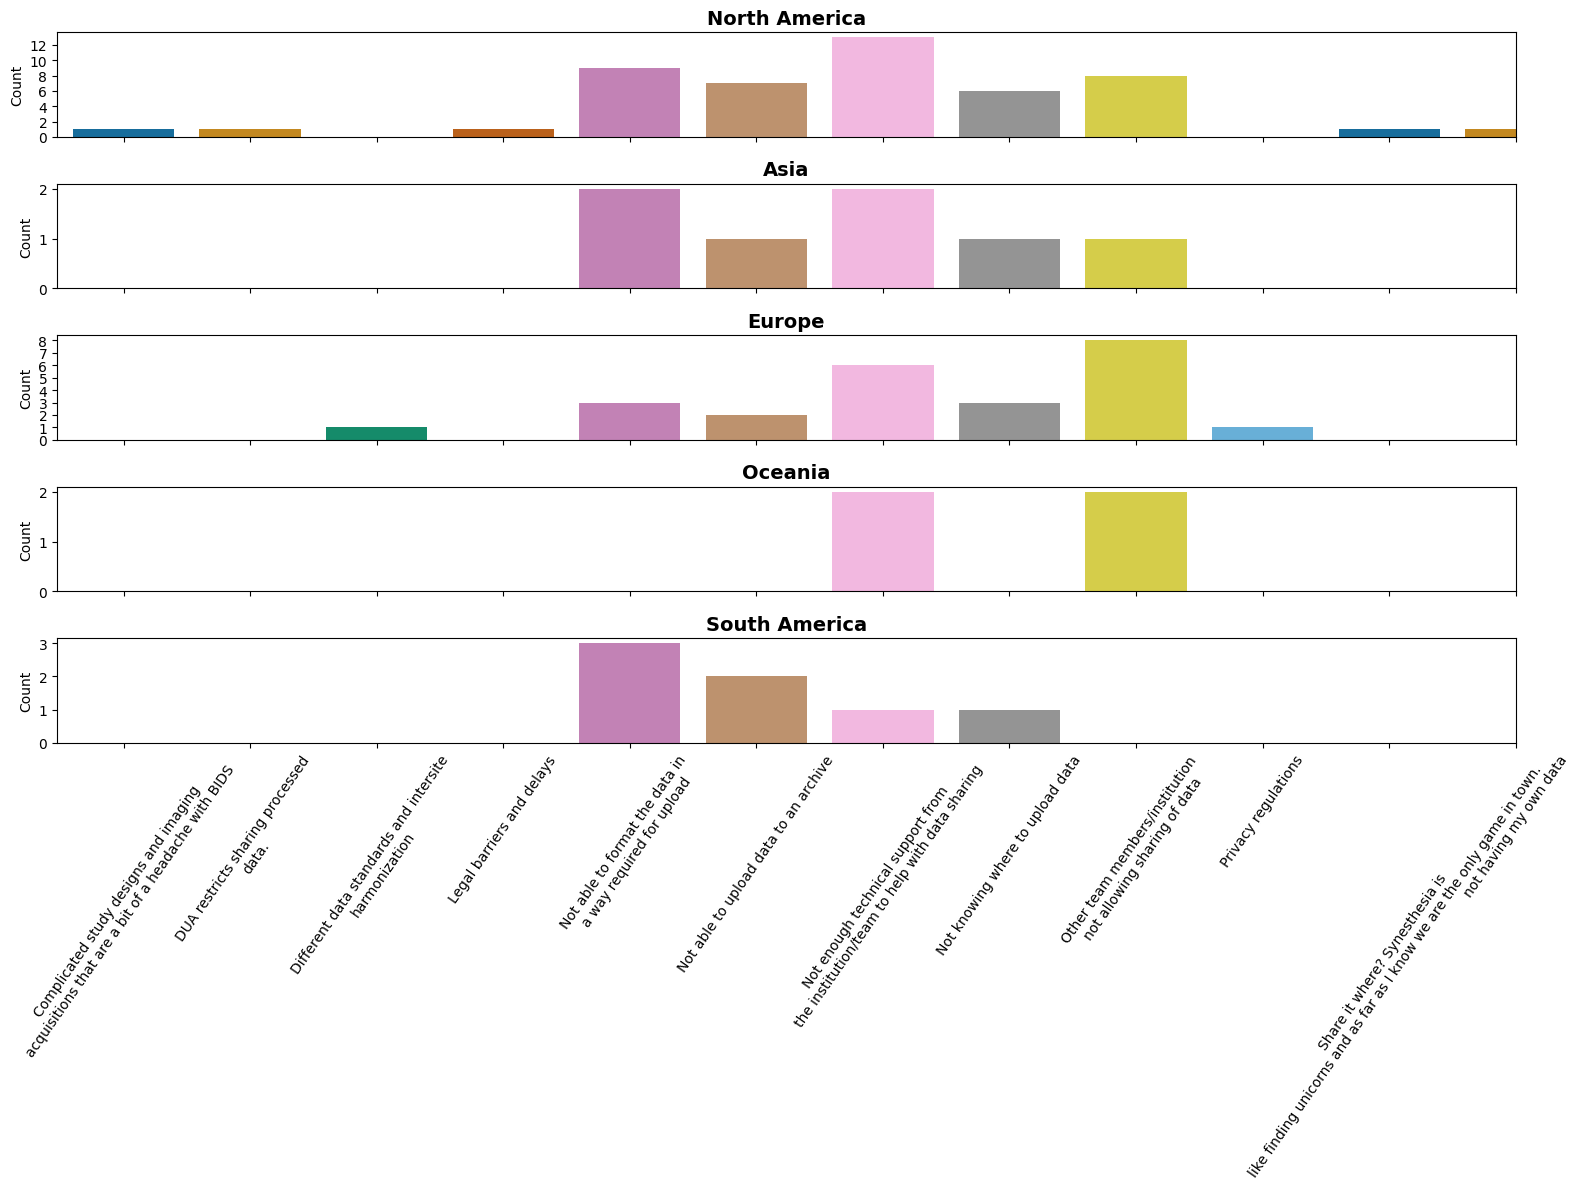

In [249]:
plot_categorical_by_continent(
    survey,
    "What are the top 3 challenges you have encountered while sharing data? (Can select fewer than 3)",
    "Data Sharing Challenges",
)

/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_name, y='Count', data=count_df, palette='colorblind', ax=ax)
/home/jdkent/projects/BRIDGESurvey/.bsurvey/lib/python3.8/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/tmp/ipykernel_304359/2956101618.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be rem

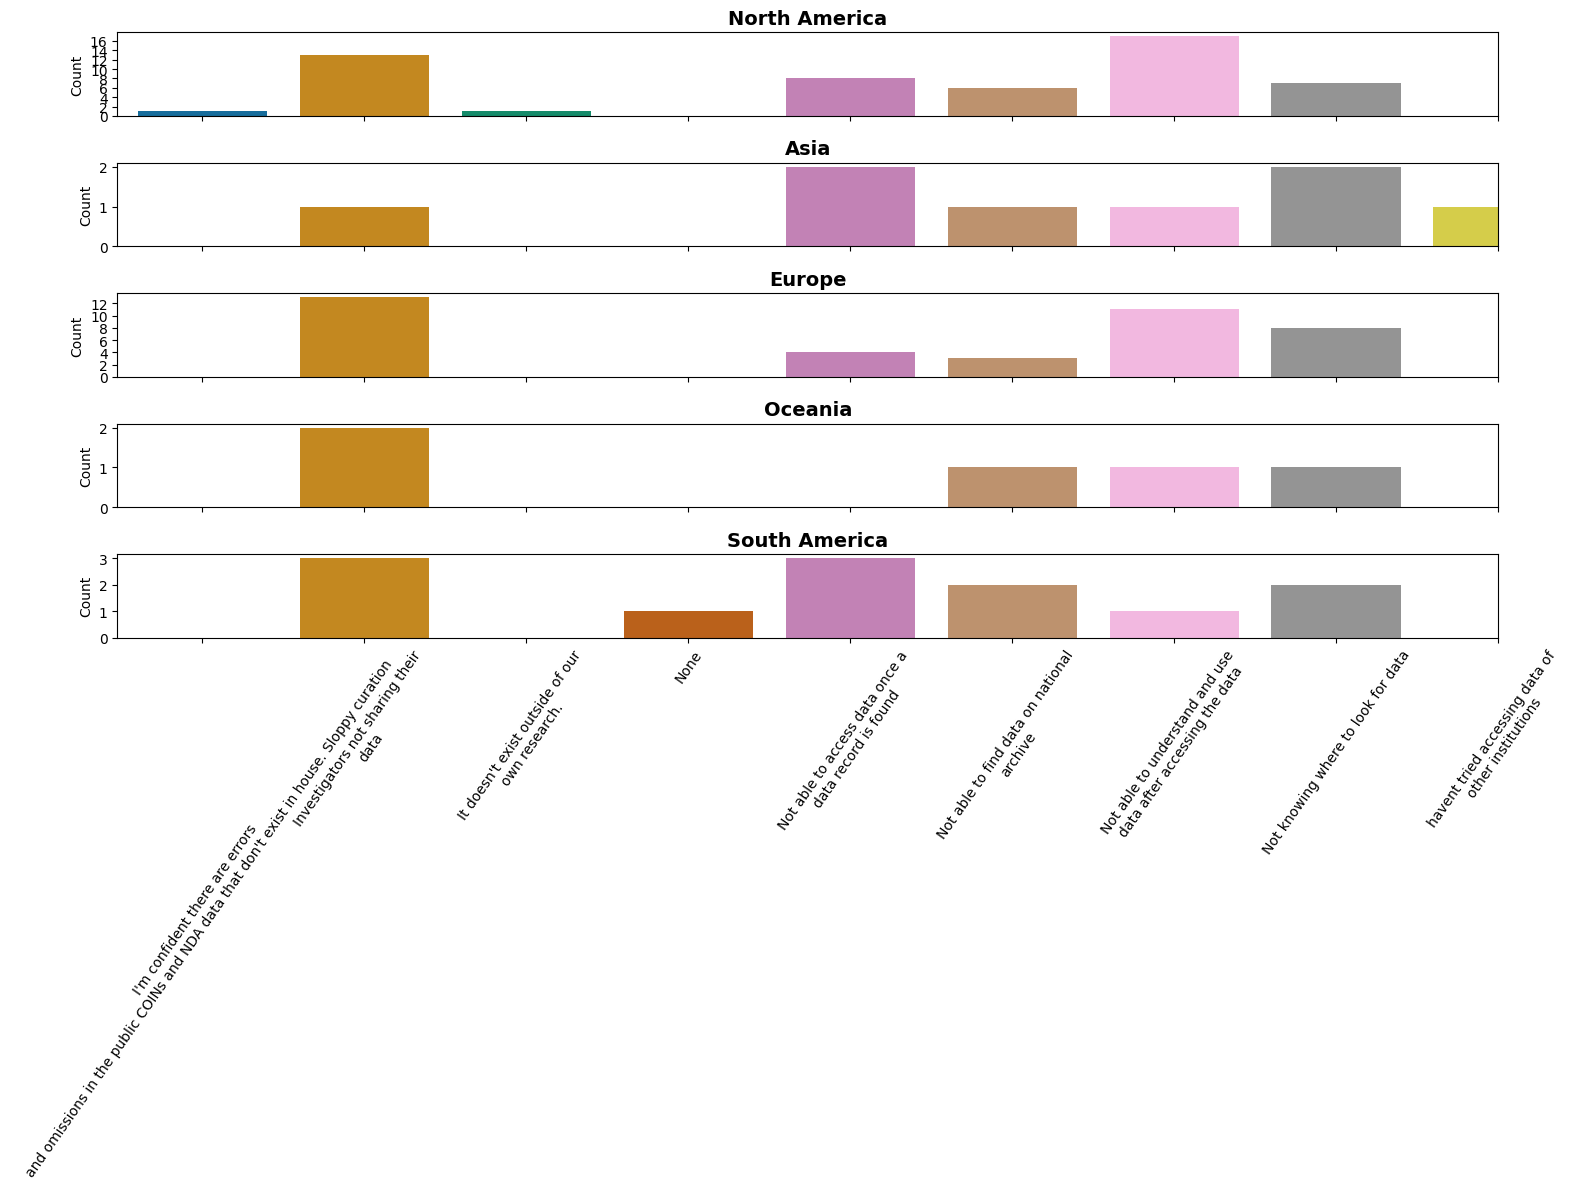

In [250]:
plot_categorical_by_continent(
    survey,
    "What are the top 3 challenges you have encountered to access data? (Can select fewer than 3)",
    "Data Access Challenges",
    {"I'm confident there are errors and omissions in the public COINs and NDA data that don't exist in house. Sloppy curation "},
)